# Ensemble Models Demystified (with Python)

In [1]:
from IPython.display import Image  
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

# My helpers -- check the github repo
from helpers import get_tree_as_image, plot_gb_mae, plot_rf_mae, plot_n_predictions_rf, plot_residuals_gb

## 1. Find some data

Data from many posts on Facebook pages.

Download: https://archive.ics.uci.edu/ml/datasets/Facebook+Comment+Volume+Dataset

Or directly use the copy in my Github [repo](https://github.com/klemag/europython2018_walking_the_random_forest)

Features include:
- Page category
- Total number of comments on the page
- Number of comments on the page in last 24h
- etc...

The target (column 54) is the number of comments the post will receive in the next hour.

In [2]:
import pandas as pd

df = pd.read_csv("Dataset/Training/Features_Variant_1.csv", 
                 header=None,
                 names=["X" + str(i) for i in range(1, 55)])

df.sample(n=10)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54
24427,7461335,1478,218090,9,0.0,1281.0,187.132867,114.0,207.820499,0.0,...,0,0,0,0,0,1,0,0,0,7
13077,9422,7750,189,34,0.0,3.0,0.419355,0.0,0.730629,0.0,...,0,0,1,0,0,0,0,0,0,0
939,6887,0,20,19,0.0,13.0,1.270677,0.0,2.077910,0.0,...,0,0,0,0,0,0,1,0,0,0
7585,23985,178,2773,36,0.0,130.0,16.557018,10.0,19.253191,0.0,...,0,0,0,0,0,0,0,1,0,2
20342,25281,280,65,39,0.0,73.0,19.309645,14.0,15.016423,0.0,...,0,0,1,0,0,0,0,0,0,17
22762,3032492,4584,114769,9,0.0,571.0,24.915888,8.0,64.156951,0.0,...,0,0,0,0,0,0,1,0,0,15
13928,63888,0,1564,24,0.0,69.0,10.562500,6.0,12.521076,0.0,...,0,1,0,0,1,0,0,0,0,0
36031,668834,4,42523,9,0.0,1405.0,112.298755,89.0,123.095019,0.0,...,0,0,0,0,0,0,0,1,0,4
40541,1426027,0,8025,1,0.0,214.0,9.719008,3.0,29.129016,0.0,...,0,0,0,0,0,0,0,1,0,0
38548,684014,0,72208,9,0.0,840.0,58.875622,31.0,98.140976,0.0,...,1,0,0,0,0,0,0,1,0,3


In [3]:
df.shape

(40949, 54)

Get features and target

In [4]:
X = df.iloc[:,:53]
y = df.iloc[:,53]

Split dataset into training & testing set

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

## 2. Weak learners -  Decision Trees

* Can capture complex relationship in the data [can get good enough accuracy]
* Overfits easily [good to create different models]

In [6]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=2)

In [7]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

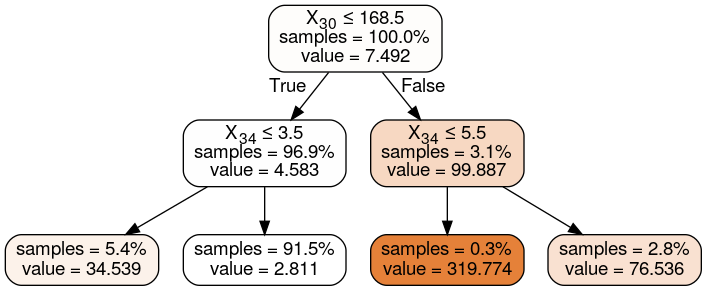

In [8]:
Image(get_tree_as_image(dt))

In [9]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(dt.predict(X_test), y_test)

7.7940505537044915

Good, but that a really simplistic model. In practice we might want to add more complexity to capture more complex relationships in the data than three binary rules. Let's increase the depth of our tree!

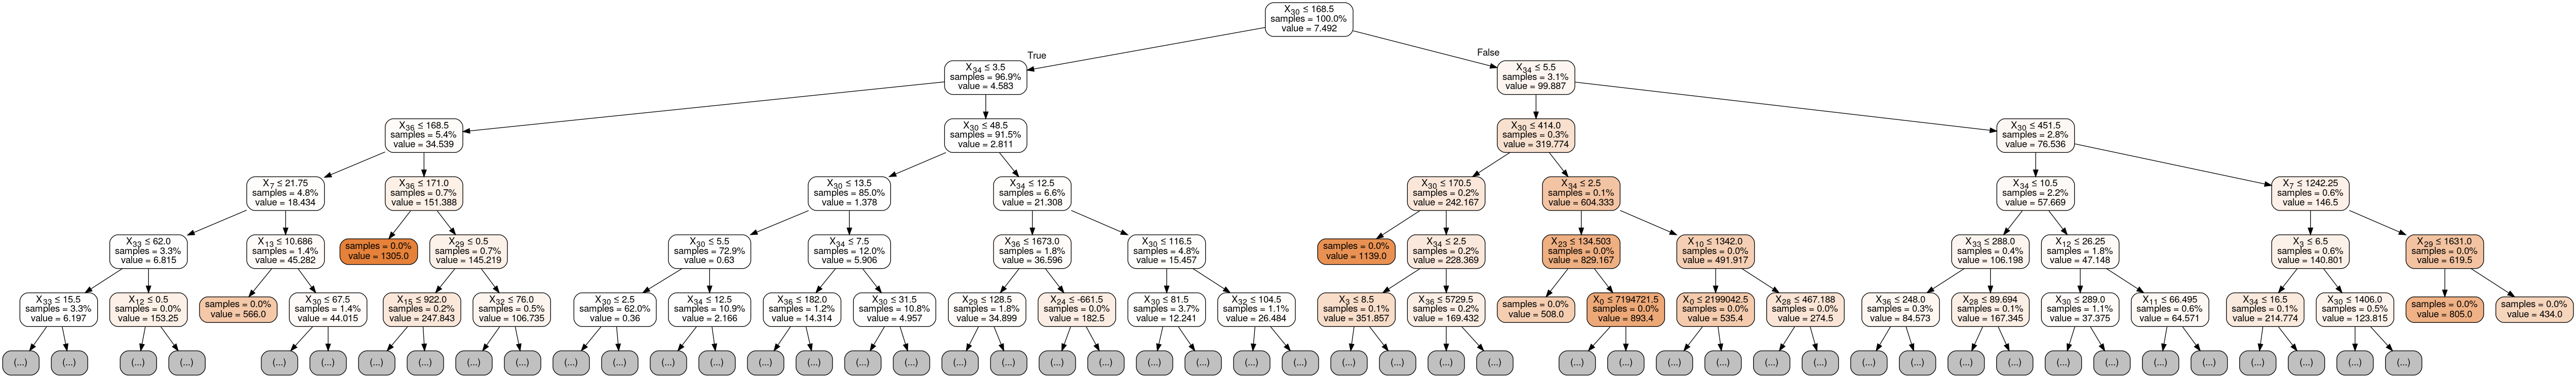

In [10]:
dt = DecisionTreeRegressor(max_depth=12)
dt.fit(X_train, y_train)
Image(get_tree_as_image(dt))

In [11]:
mean_absolute_error(dt.predict(X_test), y_test)

5.42720409269624

MAE has decreased a little. But if we look at the plot, we see that some nodes are only representative of a few data points (0.0% of the data). 

That seems like overfitting to noise, how can we prevent that without reducing our max depth? 

Here comes `min_samples_split`, the minimum number of samples required to make a split.

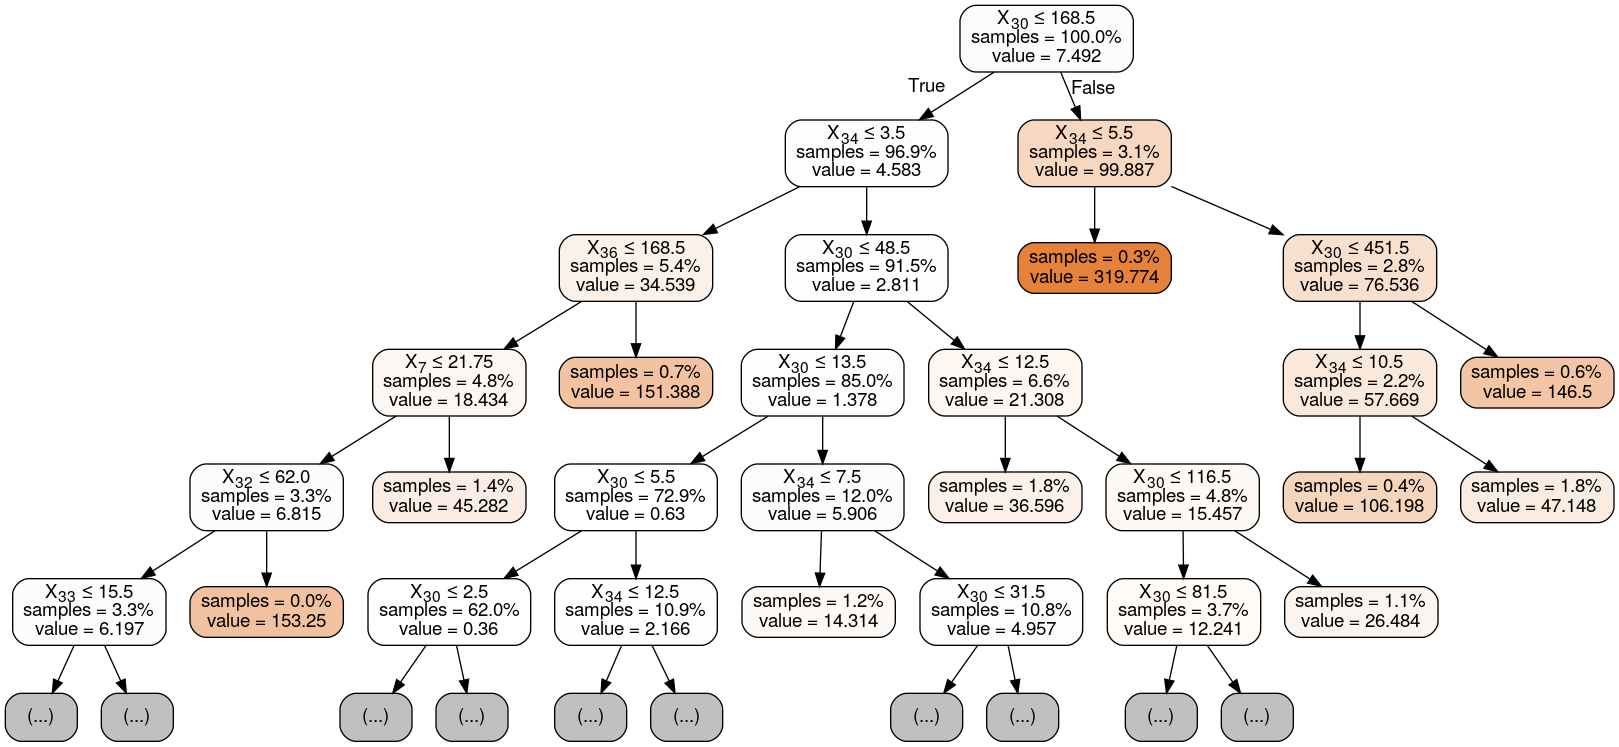

In [12]:
dt = DecisionTreeRegressor(max_depth=12, min_samples_split=.02)
dt.fit(X_train, y_train)
Image(get_tree_as_image(dt))

In [13]:
mean_absolute_error(dt.predict(X_test), y_test)

5.008792432502769

This tree seems to better generalise!

## 3. Bagging - Random Forest

![](img/bagging-diagram.png)

In order to build diverse trees we can:
- Train each on a subsample of observations (bootstrap)
- Train each on a subsample of features
- Loosely constrain trees to let them overfit (but not too much)

In [14]:
from sklearn.ensemble import RandomForestRegressor

Let's start with 15 trees, without using the boostrap and feature sampling techniques and keeping the trees well constrained.

In [15]:
rf = RandomForestRegressor(
    # Tree parameters
    max_depth=5, min_samples_split=.1,

    # Ensemble parameters
    n_estimators=15, max_features=None, bootstrap=False,

    # Misc
    random_state=42, n_jobs=-1)

In [16]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=5,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.1,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Check MAE

In [17]:
mean_absolute_error(rf.predict(X_test), y_test)

6.418274082768221

Look at estimators individually

In [18]:
rf.estimators_

[DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=0.1, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1608637542, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=0.1, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1273642419, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=0.1, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1935803228, splitter='best'),
 DecisionTreeRegressor(crite

In [19]:
# Get the first tree
tree = rf.estimators_[0]

In [20]:
mean_absolute_error(tree.predict(X_test), y_test)

6.418274082768221

Check MAE of each single tree

In [21]:
[mean_absolute_error(tree.predict(X_test), y_test) for tree in rf.estimators_]

[6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221]

Let's plot it

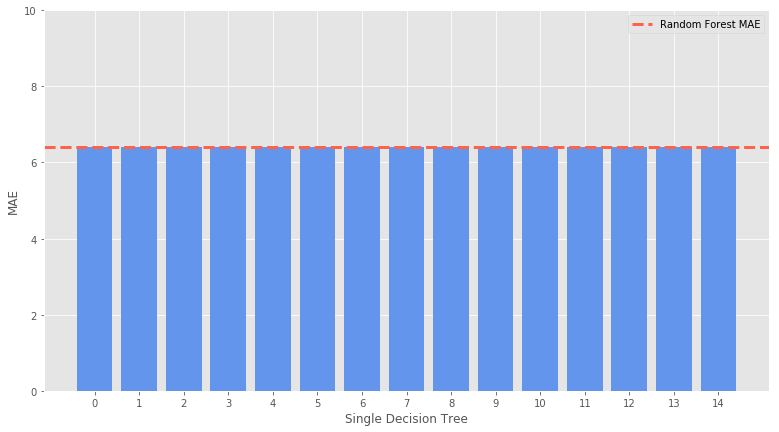

In [22]:
plot_rf_mae(rf, X_test, y_test)

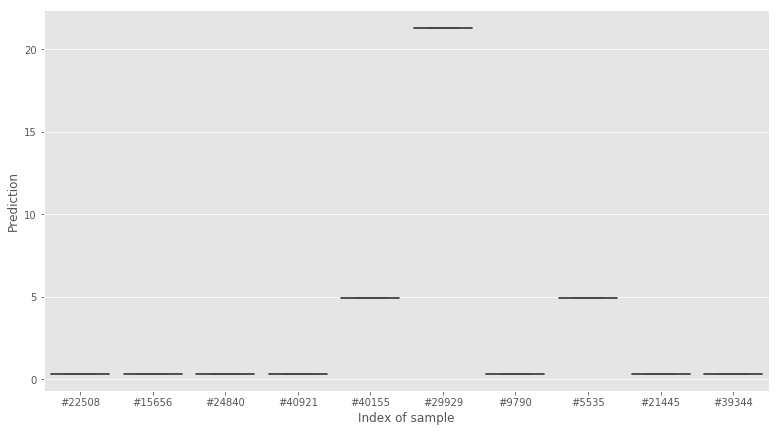

In [23]:
plot_n_predictions_rf(rf, X_test)

All trees have the exact same MAE. Our ensemble isn't better than a single tree. Let's try again by adding both boostrap and feature sampling.

In [24]:
rf = RandomForestRegressor(
    # Tree parameters
    max_depth=5, min_samples_split=.1,
    
    # Ensemble parameters
    n_estimators=15, max_features="auto", bootstrap=True,

    # Misc
    random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_absolute_error(y_pred, y_test)

6.120134164784247

Check MAE of the single trees

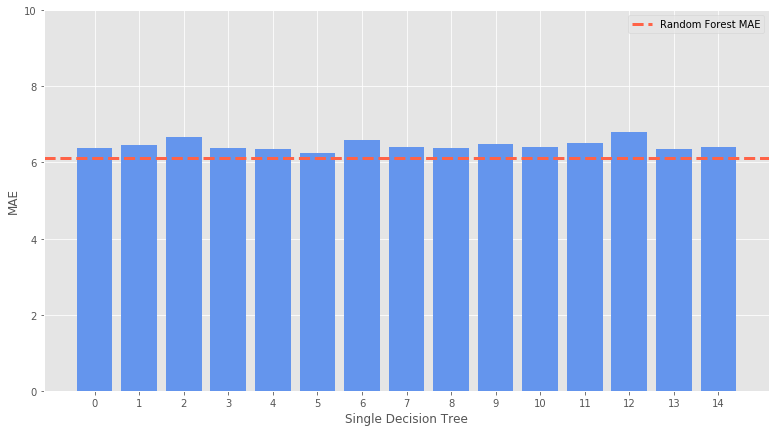

In [25]:
plot_rf_mae(rf, X_test, y_test)

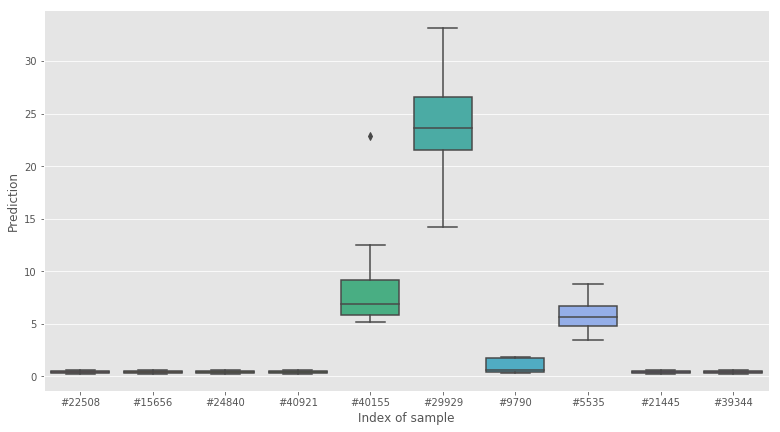

In [26]:
plot_n_predictions_rf(rf, X_test)

Finally let's make our trees overfit more easily by increasing `max_depth` and decreasing the `min_sample_split` constraint.

In [27]:
rf = RandomForestRegressor(
    # Tree parameters
    max_depth=15, min_samples_split=.001,
    
    # Ensemble parameters
    n_estimators=15, max_features="auto", bootstrap=True,

    # Misc
    random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_absolute_error(y_pred, y_test)

4.050547131322777

Again, check accuracy on individual trees

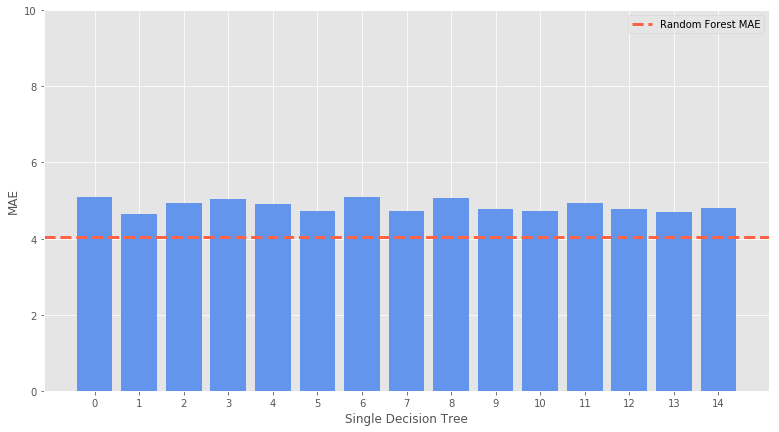

In [28]:
plot_rf_mae(rf, X_test, y_test)

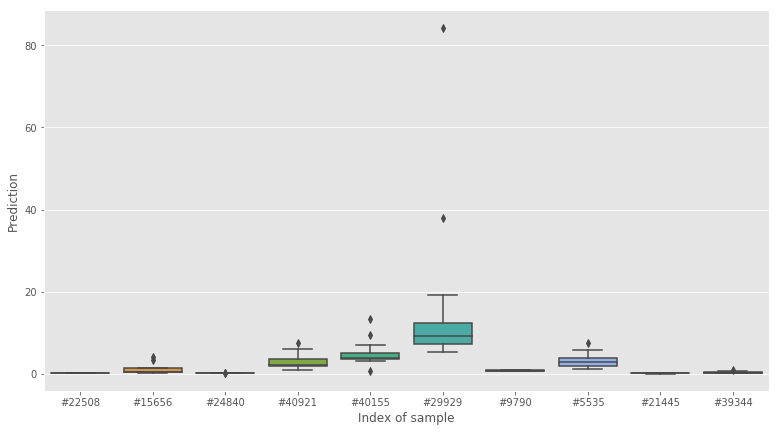

In [29]:
plot_n_predictions_rf(rf, X_test)

## 4. Boosting - Gradient Boosting

![](img/boost-diagram.png)

Here we build trees sequentially. Each new tree is trained to correct the errors of the previous ones. From the second tree, we use the residuals (difference between predicted value and actual one) as new target.

With two many stages, it can overfit to noise
- Need to keep small, constrained trees
- Need to make sure we don't have too many stages

Can also keep the trees different to benefit from the ensemble advantage. We can use `subsample` and `max_features` for that.

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

In [31]:
gb = GradientBoostingRegressor(
    # Keep trees well constrained
    max_depth=12, min_samples_split=.05,
    
    # Ensemble parameters
    n_estimators=5, subsample=.8, max_features="auto", learning_rate=.5,
 
    # Misc.
    random_state=42)

In [32]:
gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.5, loss='ls', max_depth=12,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=0.05,
             min_weight_fraction_leaf=0.0, n_estimators=5, presort='auto',
             random_state=42, subsample=0.8, verbose=0, warm_start=False)

Check overall MAE

In [33]:
mean_absolute_error(gb.predict(X_test), y_test)

5.123788858955904

Here the MAE of a single tree does not make sense since each new tree is correcting the error of the previous ones. But in `sklearn` we can get the MAE at given stage, including all trees from the previous stages.

In [34]:
[mean_absolute_error(y_pred, y_test) for y_pred in gb.staged_predict(X_test)]

[7.667186671362484,
 6.259327833636609,
 5.789045357355478,
 5.53595615940551,
 5.123788858955904]

Let's visualise it

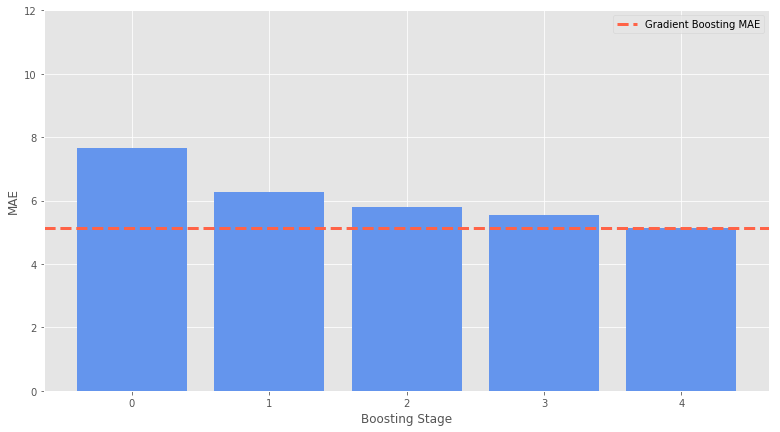

In [35]:
plot_gb_mae(gb, X_test, y_test)

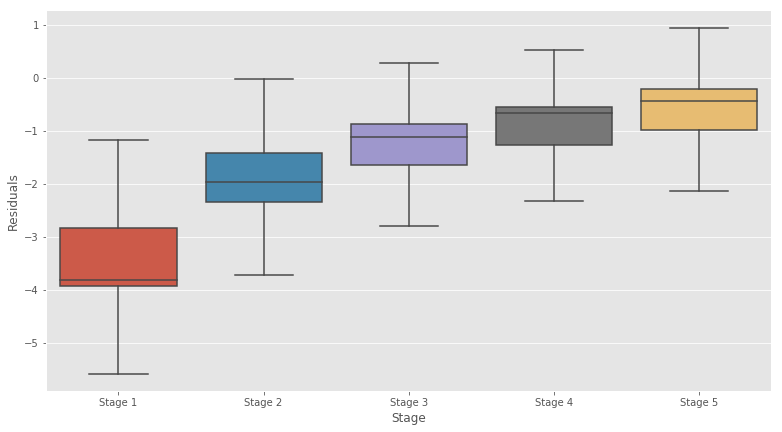

In [36]:
plot_residuals_gb(gb, X_train, y_train, step_size=1)

MAE is decreasing with each new tree that we add. Maybe we're underfitting and could still get better by adding more trees? Let's try it.

In [37]:
gb = GradientBoostingRegressor(
    # Keep trees well constrained
    max_depth=12, min_samples_split=.05,
    
    # Ensemble parameters
    n_estimators=20, subsample=.8, max_features="auto", learning_rate=.5,
 
    # Misc.
    random_state=42)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
mean_absolute_error(y_pred, y_test)

4.8952094730085385

Overall MAE is better, let's check the MAE at every stage.

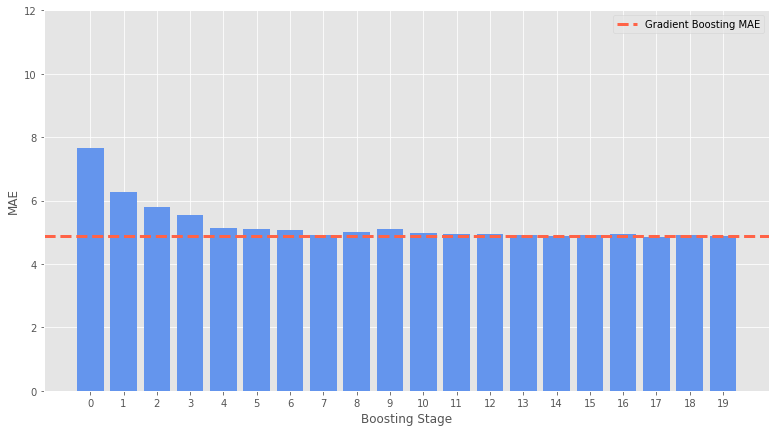

In [38]:
plot_gb_mae(gb, X_test, y_test)

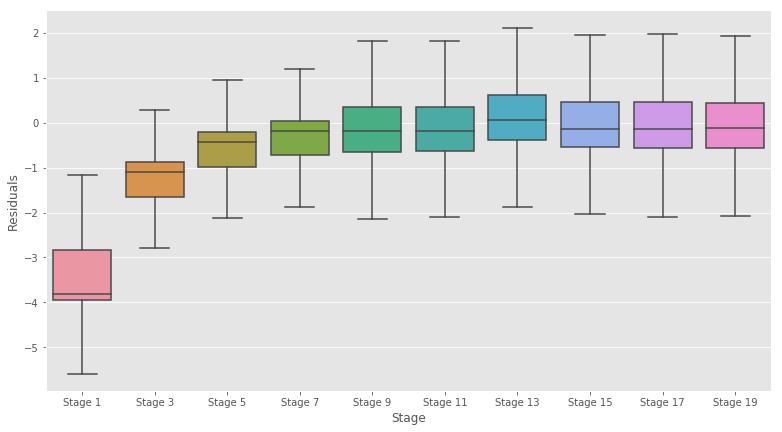

In [39]:
plot_residuals_gb(gb, X_train, y_train, step_size=2)

Here adding more trees doesn't seem to help after a few stages and the MAE starts to converge quickly. We need to loosen the constraints on our trees so they get more complex.

Let's see what happens if we loosen the constraints a lot and let our trees overfit

In [40]:
gb = GradientBoostingRegressor(
    # Keep trees well constrained
    max_depth=12, min_samples_split=.001,
    
    # Ensemble parameters
    n_estimators=20, subsample=.8, max_features="auto", learning_rate=.5,
 
    # Misc.
    random_state=42)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
mean_absolute_error(y_pred, y_test)

4.917075123026421

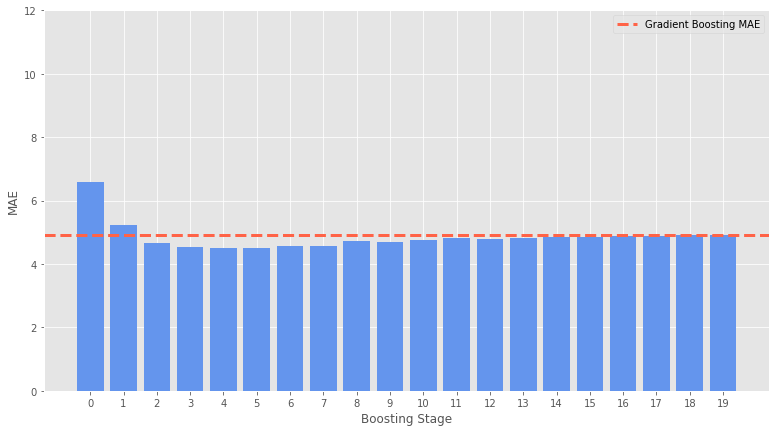

In [41]:
plot_gb_mae(gb, X_test, y_test)

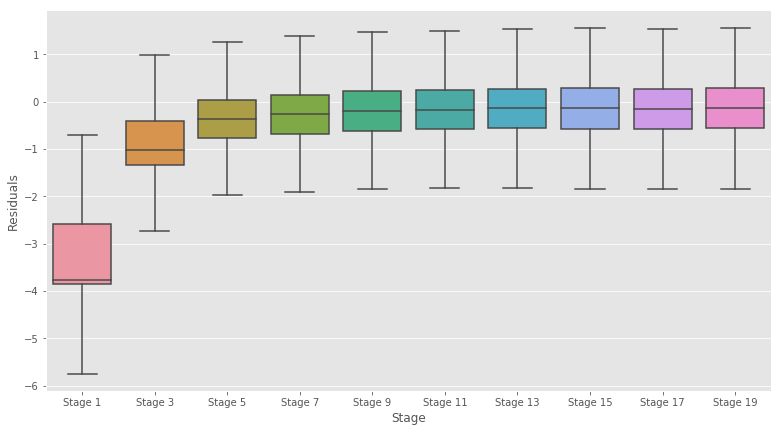

In [42]:
plot_residuals_gb(gb, X_train, y_train, step_size=2)

MAE went down and starting going up again after some stages. Our model started overfitting. We can decrease the number of trees, learning rate or add more constrains on our weak learners.

Now we'll decrease the learning rate, so we can build more trees without overfitting (regularisation). Additionally we make the constraint harder on max_depth

In [43]:
gb = GradientBoostingRegressor(
    # Keep trees well constrained
    max_depth=8, min_samples_split=.005,
    
    # Ensemble parameters
    n_estimators=30, subsample=.8, max_features="auto", learning_rate=.1,
 
    # Misc.
    random_state=42)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
mean_absolute_error(y_pred, y_test)

4.210291108821273

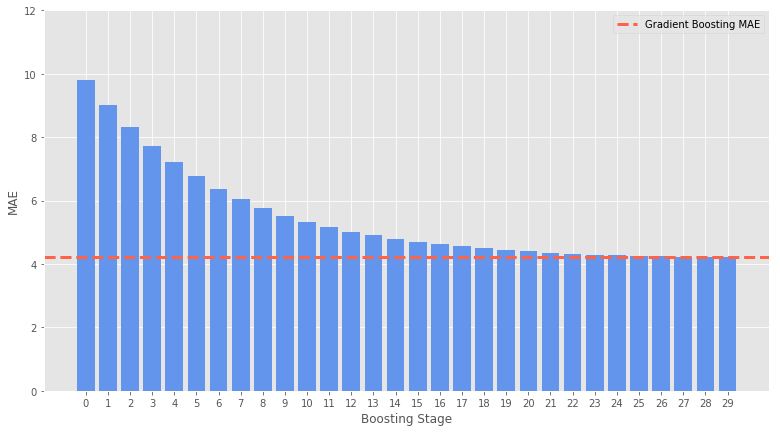

In [44]:
plot_gb_mae(gb, X_test, y_test)

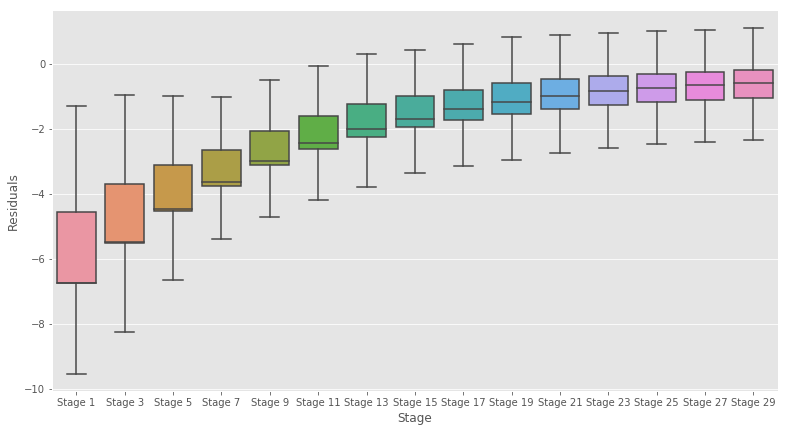

In [45]:
plot_residuals_gb(gb, X_train, y_train, step_size=2)

The sklearn implementation of gradient boosting cannot be run in parallel, hence it can be quite slow when many trees have to be trained. Several popular libraries implement optimised version of gradient boosting and can run in parallel, such as `xgboost`, `lightgbm` and `catboost`.

## 5. Other boosting libraries - XGBoost, LightGBM, CatBoost

In [46]:
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [47]:
xgb = XGBRegressor(n_estimators=40, max_depth=8, min_samples_split=.005, n_jobs=-1)
xgb.fit(X_train, y_train)
mean_absolute_error(xgb.predict(X_test), y_test)

3.908602742169706

In [48]:
lgb = LGBMRegressor(n_estimators=40, max_depth=8, min_samples_split=.005, n_jobs=-1)
lgb.fit(X_train, y_train)
mean_absolute_error(lgb.predict(X_test), y_test)

4.071846028113166

In [49]:
ctb = CatBoostRegressor(n_estimators=60, max_depth=8)
ctb.fit(X_train, y_train)
mean_absolute_error(ctb.predict(X_test), y_test)

0:	learn: 37.1157458	total: 105ms	remaining: 6.2s
1:	learn: 36.5590871	total: 169ms	remaining: 4.91s
2:	learn: 36.0332084	total: 233ms	remaining: 4.43s
3:	learn: 35.4820468	total: 291ms	remaining: 4.08s
4:	learn: 34.9660887	total: 353ms	remaining: 3.88s
5:	learn: 34.4782426	total: 418ms	remaining: 3.77s
6:	learn: 33.9982085	total: 480ms	remaining: 3.63s
7:	learn: 33.5205152	total: 543ms	remaining: 3.53s
8:	learn: 33.0709900	total: 604ms	remaining: 3.42s
9:	learn: 32.6562810	total: 665ms	remaining: 3.33s
10:	learn: 32.2827217	total: 726ms	remaining: 3.23s
11:	learn: 31.9272575	total: 791ms	remaining: 3.17s
12:	learn: 31.5366806	total: 852ms	remaining: 3.08s
13:	learn: 31.1422614	total: 919ms	remaining: 3.02s
14:	learn: 30.7779004	total: 989ms	remaining: 2.96s
15:	learn: 30.4506787	total: 1.05s	remaining: 2.88s
16:	learn: 30.1424821	total: 1.11s	remaining: 2.81s
17:	learn: 29.8228184	total: 1.17s	remaining: 2.74s
18:	learn: 29.5186861	total: 1.24s	remaining: 2.67s
19:	learn: 29.2343569	t

4.090693045626558